# COMP 551: Applied Machine Learning
## MiniProject 3: Classification of Image Data

Mustafa Javed - 260808710 <br>
  <br>



Credits: Parts of this code has been given by Prof Rabbany and the teaching Staff during tutorials for COMP 551 with due permission to reuse the code

## Imports and Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.decomposition import PCA

In [ ]:
# ONLY RUN THIS BLOCK IF YOU INTEND TO SAVE THE MODEL WEIGHTS

#mount drive
from google.colab import drive
drive.mount('/content/drive')

#define images path.
path = '/content/drive/My Drive/McGill/COMP 551/model_weights/'

Mounted at /content/drive


## Task 1: Acquire the data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(train_images.shape)

X_train = np.reshape(train_images, (train_images.shape[0],train_images.shape[1]*train_images.shape[2])) #vectorize the train image
X_train = X_train - np.mean(X_train, axis = 0)                                                          #center the train images
X_train_unnorm = X_train
X_train_norm = X_train / 255.0                                                                          #normalize the train images
Y_train = train_labels

X_test = np.reshape(test_images, (test_images.shape[0], test_images.shape[1]*test_images.shape[2]))    #vectorize the test image
X_test = X_test - np.mean(X_test, axis = 0)                                                            #center the train images
X_test_unnorm = X_test
X_test_norm = X_test / 255.0                                                                           #normalize the train images
Y_test = test_labels

print(X_train_norm.shape)
print(X_test_norm.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 784)
(10000, 784)


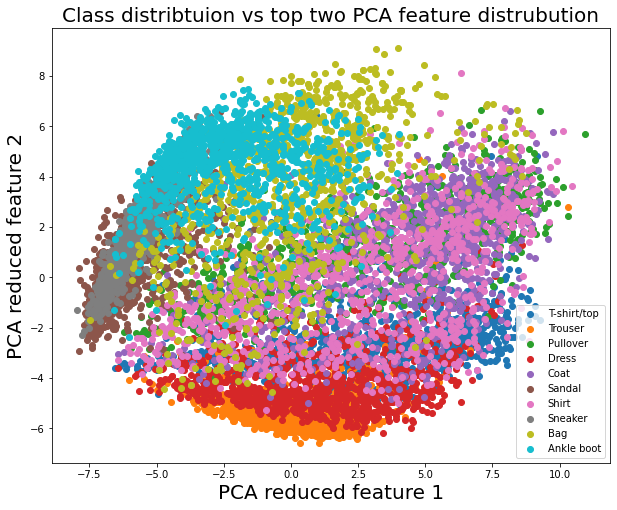

In [ ]:
pca = PCA(2)
X_pca = pca.fit_transform(X_train_norm[:10000])

plt.figure(figsize=(10,8))
for i in range(np.max(Y_train) + 1):

  x_scatter = X_pca[Y_train[:10000] == i,0]
  y_scatter = X_pca[Y_train[:10000] == i,1]

  plt.scatter(x_scatter, y_scatter, label = class_names[i] ,marker='o', alpha=1)

plt.title("Class distribtuion vs top two PCA feature distrubution", fontsize=20)
plt.xlabel("PCA reduced feature 1", fontsize=20)
plt.ylabel("PCA reduced feature 2", fontsize=20)
plt.legend()
plt.show()


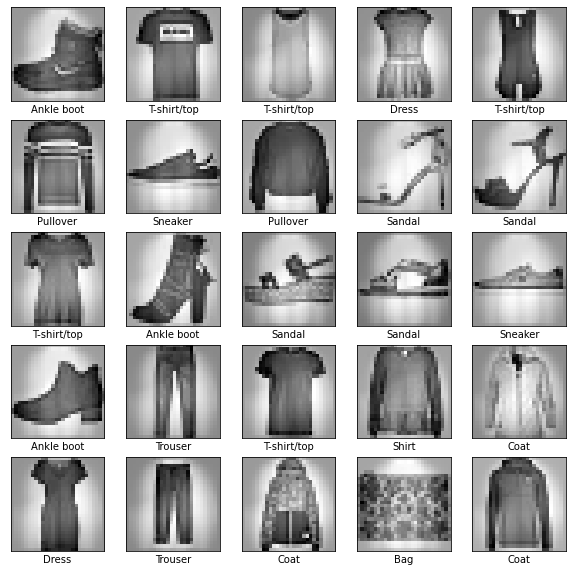

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((28,28)), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

##Task 2: Implement a Multilayer Perceptron

In [ ]:
def softmax(z):
  exp_z = np.exp(z - z.max(axis = 1)[:,None])
  return (exp_z / np.sum(exp_z,axis = 1)[:,None])

logistic = lambda z: 1./ (1 + np.exp(-z))
tanh = lambda z: np.tanh(z)                 #(np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
ReLU = lambda z:np.maximum(z,0)
LeakyReLU = lambda z : np.maximum(z,0) + 0.2*np.minimum(0,z)

Dlogistic = lambda z: z * (1 - z)
Dtanh = lambda z: 1 - z**2
DReLU = lambda z: (z > 0) * (1.0)
DLeakyReLU = lambda z : (z > 0) * (1.0) + (z < 0) * 0.2


class MLP:
  '''
  MLP class implements a multilayer preceptron model.
  The final activation function is softmax, therefore the model can be used for softmax regression.

  Parameters:
    hidden_layers: list[int] :
      Number of hidden layer units in a list form. Default is 1 hidden-layer with 64 units.
    activations: list[str] : 
      Action function for each hidden layer in a list form. Default is 1 hidden-layer with 'logistic' activation
      Supported activation functions are ['logistic', 'tanh', 'ReLU', 'LeakyReLU']
    dropout : list[float] :
      Dropout for each layer. Dropout can be set for input and hidden layers but not output layer.
      Default dropout is set to 0

  Returns:
    model instance.  
  '''
  def __init__(self,  hidden_layers = [64], activations=['logistic'], dropout = None, leaky_rely_r = 0.2):
    
    assert len(hidden_layers) == len(activations),   "Number of activation layers must be equal number of hidden layers"
    if dropout is not None:
      dropout = np.array(dropout)
      assert len(hidden_layers)+1 == len(dropout),     "Number of dropout layers must be equal number of hidden layers + 1 for input layer"
      assert (dropout>=0).all() and (dropout<=1).all(), "Dropout must be between 0 and 1"
    
    self.hidden_layers = hidden_layers
    self.dropout = dropout
    self.activations = []
    self.activations_dervatives = []

    print("hidden layer activation:",activations)
    
    for func in activations:
      if func == 'logistic':
        self.activations.append(logistic)
        self.activations_dervatives.append(Dlogistic)
      elif func == 'ReLU':
        self.activations.append(ReLU)
        self.activations_dervatives.append(DReLU)
      elif func == 'tanh':
        self.activations.append(tanh)
        self.activations_dervatives.append(Dtanh)
      elif func == 'LeakyReLU':
        self.activations.append(LeakyReLU)
        self.activations_dervatives.append(DLeakyReLU)
      else:
        print("unknown activation function, using ReLU as deafult")
        self.activations.append(ReLU)
        self.activations_dervatives.append(DReLU)
  
  def backprop(self, x, y, params):
    '''
    implements a forward pass to calculate the values
    followed by a in a backward pass calculate the derivatives

    Returns:
    gradient 
    '''
    N,D = x.shape
    C = np.max(y)+1    
    Z = [None] * (len(self.hidden_layers)+1)

   #Forward Pass 
    if self.dropout is None:
      Z[0] = x
    else:
      Z[0] = x*(np.random.rand(x.shape[0], x.shape[1]) < (1-self.dropout[0]))   # if dropout, set some input node to 0
    
    for i in range(1,len(self.hidden_layers)+1):
      Z[i] = self.activations[i-1](np.dot(Z[i-1], params[i-1])) #N x Mi   Zi = Vi x Zi-1
      if self.dropout is not None:
        dropout = (np.random.rand(Z[i].shape[0], Z[i].shape[1]) < (1-self.dropout[i])) # if dropout, set some node outputs to 0
        Z[i] = Z[i]*dropout

    w = params[-1]  
    yh = softmax(np.dot(Z[-1], w)) #N x C  

    #Backward Pass   
    yc = np.zeros((N, C))
    yc[np.arange(N),y] = 1     # broadcast labels to one-hot encoding to calculate loss
    dy = yh - yc #N x C         # calculate loss
    
    dw = np.dot(Z[-1].T, dy)/N #M x C 
    
    dZ = [None] * (len(self.hidden_layers)+1)
    dV = [None] * (len(self.hidden_layers)+1)
    dZ[-1] = dy
    dV[-1] = x
    
    for i in range(len(self.hidden_layers),0,-1):
      dZ[i-1] = np.dot(dZ[i], params[i].T)* (self.activations_dervatives[i-1](Z[i]))  #N x Mi
      dV[i-1] = np.dot(Z[i-1].T, (dZ[i-1]))/N #D x M
      
    dparams = dV[:-1]+[dw]     
    return dparams


  def fit(self, x, y, optimizer, track_matrices = False):
    '''
    Train the model over given data.
    Parameters:
      x: ndarray :
        Training data matrix of shape NxD, where N is number of instances and D is number of features.
      y: ndarray : 
        Training data label of shape N, where N is number of instances.
      optimizer: GradientDescent:
        Instance of GradientDescent class that runs gradient descent.
      track_matrices: bool :
        If trac_ matrices is set to True, return dict of metrices will have loss and accuracy per epoch.
        Setting this to True will increase execution time

    Returns:
      model: MLP: 
        Instance of the model with trained weights.
      mertices: dict[str:list] :  
        The metrices dict will have four entries: with the following key->values
        'training_loss' -> [] of training loss per epoch
        'training_acc' -> [] of training accuracy per epoch
        'testing_loss' ->  [] of testing loss per epoch
        'testing_acc' -> [] of testing accuracy per epoch
    '''
    N,D = x.shape
    C = np.max(y)+1

    Ms = [D] + self.hidden_layers        #[D, M1, M2 ....]
    V = [None] * len(self.hidden_layers)
    
    for i in range(len(self.hidden_layers)):
      V[i] = np.random.randn(Ms[i],Ms[i+1])*0.01  #Mi x Mi+1
      print("Weights of hidden layer {} = {}".format(i,V[i].shape))

    w = np.random.randn(Ms[-1],C)*0.01  #M x C
    print("Final layer weights = ", w.shape)

    params0 = V + [w]
    self.params = params0
    metrices = optimizer.run(self, self.backprop, x, y, track_matrices = track_matrices)
    return self, metrices
  
  def predict(self, x):
    '''
    Predict the label of X  using the model.
    Parameters:
      x: ndarray :
        Test data matrix of shape NxD, where N is number of instances and D is number of features. 
    Returns:
      yh: ndarray :
      Matrix of softmax values for each class of shape NxC where N is number of test instances and C is number of classes.
    '''
    Z = [None] * (len(self.hidden_layers)+1)
    Z[0] = x
    
    for i in range(1,len(self.hidden_layers)+1):
      Z[i] = self.activations[i-1](np.dot(Z[i-1], self.params[i-1])) #N x Mi
    
    w = self.params[-1]
    yh = softmax(np.dot(Z[-1], w)) #N x C
    return yh
        

class GradientDescent:
  '''
  GradientDescent class implements a optimizer that would perform gradient descent.

  Parameters:
    learning_rate: double :
      The learning rate of the optimizer. Default is 0.01.
   max_epochs: int : 
      Maximum number of training iteration over the entire dataset. Default is 1000.
  epsilon: dobule :
      Gradient tolerance below which the gradient descent would stop. Default is 1e-8.
  batch_size : int :
      Batch size for min batch gradient descent. For SGD, set to 1. Default is 1000.
      If len(dataset) < batch_size, all instances will be used per iteration.
  Returns:
    GradientDescent instance.  
  '''

  def __init__(self, learning_rate = 1e-3, max_epochs=1e3, epsilon=1e-8, batch_size = 1000):
    self.learning_rate = learning_rate
    self.max_epochs = max_epochs
    self.epsilon = epsilon
    self.batch_size = batch_size
      
  def run(self, model, gradient_fn, x, y, track_matrices):
    
    metrices = {}
    metrices['training_loss'] = []
    metrices['training_acc'] = []
    metrices['testing_loss'] = []
    metrices['testing_acc'] = []
    
    indices = np.arange(len(y))
    K = len(indices)//self.batch_size
    if K <=0:
      K = 1
    batches =  np.array_split(indices, K)
    training_loss = []
    
    norms = np.array([np.inf])
    t = 1
    while np.any(norms > self.epsilon) and t < self.max_epochs:

      if track_matrices:
        yh = model.predict(X_train_norm) 
        y_pred = np.argmax(yh, axis = 1)
        acc = evaluate_acc(y_pred,Y_train)
        metrices['training_loss'].append(L2Loss(yh,Y_train))
        metrices['training_acc'].append(acc)

        yh = model.predict(X_test_norm) 
        y_pred = np.argmax(yh, axis = 1)
        acc = evaluate_acc(y_pred,Y_test)      
        metrices['testing_loss'].append(L2Loss(yh,Y_test))
        metrices['testing_acc'].append(acc)
      
      print("Epoch: ",t)
    
      for batch in batches:
        grad = gradient_fn(x[batch,:], y[batch], model.params)
        for p in range(len(model.params)):
            model.params[p] -= self.learning_rate * grad[p]
        norms = np.array([np.linalg.norm(g) for g in grad])
        if np.any(norms < self.epsilon):
          break
        if (batch[0]%(len(indices)//3)==0):
          print(datetime.now(), " ",batch[0],"/" , len(indices) )
      
      t += 1
    
    if t >= self.max_epochs:
      print('Max epoch reached')
    else:
      print('Minimum gradient tolerance reached, possibly vanishing gradient')

    metrices['training_loss'] = np.array(metrices['training_loss'])
    metrices['training_acc'] = np.array(metrices['training_acc'])
    metrices['testing_loss'] = np.array(metrices['testing_loss'])
    metrices['testing_acc'] = np.array(metrices['testing_acc'])
    return metrices

def evaluate_acc(y_pred, y_test):
  assert len(y_pred) == len(y_test), "target and true labels must have equal len"
  return np.sum(y_pred == y_test)/y_pred.shape[0]

def L2Loss(y_prob, y_test):
  assert len(y_prob) == len(y_test), "target and true labels must have equal len"
  yc = np.zeros((y_test.shape[0],np.max(y_test)+1))
  yc[np.arange(y_test.shape[0]),y_test] = 1
  return (((y_prob-yc)**2).sum())/(y_test.shape[0])

## Task 3: Run the experiments and report

First of all, create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs to outputs, (2) an MLP with a single hidden layer having 128 units and ReLU activations, (3) an MLP with 2 hidden layers each having 128 units with ReLU activations. It should be noted that since we want to perform classification, all of these models should have a softmax layer at the end. After training, compare the test accuracy of these three models on the Fashion-MNIST dataset. Comment on how non-linearity and network depth affects the accuracy. Are the results that you obtain expected?

Training MLP

In [ ]:
optimizer = GradientDescent(learning_rate=0.1, max_epochs=1000, batch_size=1000)

model_0 = MLP([], activations=[])
model_0, metrices_0 = model_0.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

model_1 = MLP([128], activations=["ReLU"])
model_1, metrices_1 = model_1.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

model_2 = MLP([128,128], activations=["ReLU","ReLU"])
model_2, metrices_2 = model_2.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

Streaming output truncated to the last 5000 lines.
Epoch:  331
2022-03-30 21:15:39.005259   0 / 60000
2022-03-30 21:15:39.148617   20000 / 60000
2022-03-30 21:15:39.319855   40000 / 60000
Epoch:  332
2022-03-30 21:15:39.685122   0 / 60000
2022-03-30 21:15:39.830376   20000 / 60000
2022-03-30 21:15:39.983952   40000 / 60000
Epoch:  333
2022-03-30 21:15:40.369492   0 / 60000
2022-03-30 21:15:40.509023   20000 / 60000
2022-03-30 21:15:40.660178   40000 / 60000
Epoch:  334
2022-03-30 21:15:41.039988   0 / 60000
2022-03-30 21:15:41.197868   20000 / 60000
2022-03-30 21:15:41.376568   40000 / 60000
Epoch:  335
2022-03-30 21:15:41.760485   0 / 60000
2022-03-30 21:15:41.897216   20000 / 60000
2022-03-30 21:15:42.041452   40000 / 60000
Epoch:  336
2022-03-30 21:15:42.424785   0 / 60000
2022-03-30 21:15:42.566169   20000 / 60000
2022-03-30 21:15:42.720591   40000 / 60000
Epoch:  337
2022-03-30 21:15:43.086209   0 / 60000
2022-03-30 21:15:43.231058   20000 / 60000
2022-03-30 21:15:43.412613   4000

KeyboardInterrupt: ignored

In [ ]:
# DO NOT RUN, only to save and reload models
#save model weights
np.save(path+"model_0_weights.npy", model_0.params)
np.save(path+"model_1_weights.npy", model_1.params)
np.save(path+"model_2_weights.npy", model_2.params)

np.save(path+"model_0_metrices.npy", metrices_0)
np.save(path+"model_1_metrices.npy", metrices_1)
np.save(path+"model_2_metrices.npy", metrices_2)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
# DO NOT RUN, only to save and re-load models
#load model weights
model_0.params = np.load(path+"model_0_weights.npy", allow_pickle=True).item()
model_1.params = np.load(path+"model_1_weights.npy", allow_pickle=True).item()
model_2.params = np.load(path+"model_2_weights.npy", allow_pickle=True).item()

metrices_0 = np.load(path+"model_0_metrices.npy", allow_pickle=True).item()
metrices_1 = np.load(path+"model_1_metrices.npy", allow_pickle=True).item()
metrices_2 = np.load(path+"model_2_metrices.npy", allow_pickle=True).item()

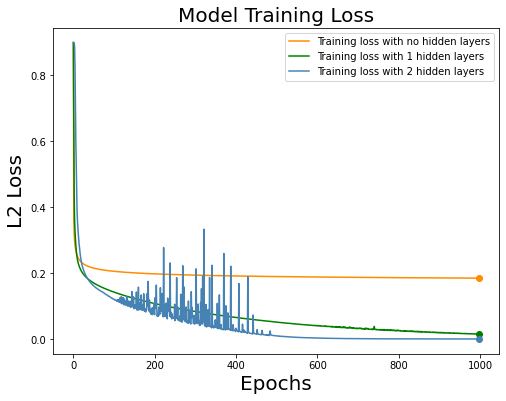

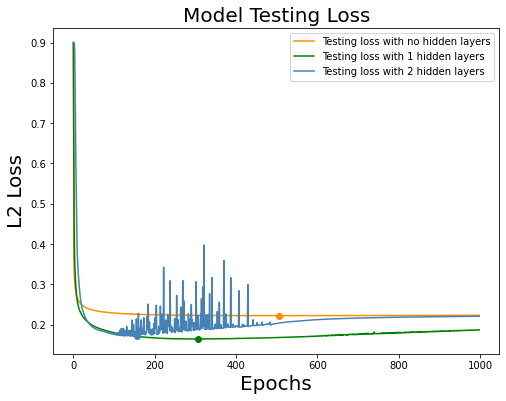

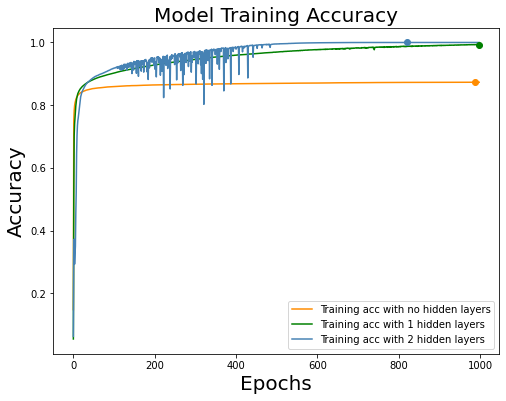

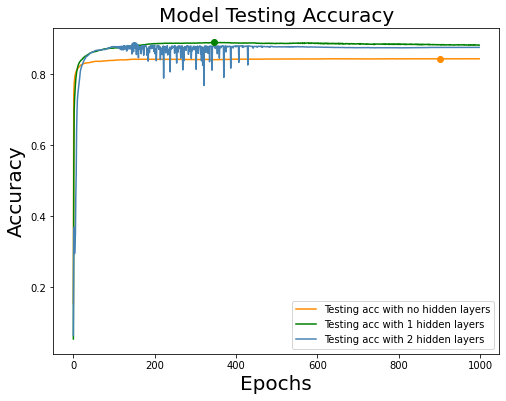

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(metrices_0['training_loss'], label = 'Training loss with no hidden layers', color='darkorange') 
plt.plot(metrices_1['training_loss'], label = 'Training loss with 1 hidden layers', color='green') 
plt.plot(metrices_2['training_loss'], label = 'Training loss with 2 hidden layers', color='steelblue')
plt.plot(np.argmin(metrices_0['training_loss']),np.min(metrices_0['training_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_1['training_loss']),np.min(metrices_1['training_loss']), marker='o', color='green')
plt.plot(np.argmin(metrices_2['training_loss']),np.min(metrices_2['training_loss']), marker='o', color='steelblue')
plt.title("Model Training Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(metrices_0['testing_loss'], label = 'Testing loss with no hidden layers', color='darkorange') 
plt.plot(metrices_1['testing_loss'], label = 'Testing loss with 1 hidden layers', color='green') 
plt.plot(metrices_2['testing_loss'], label = 'Testing loss with 2 hidden layers', color='steelblue')
plt.plot(np.argmin(metrices_0['testing_loss']),np.min(metrices_0['testing_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_1['testing_loss']),np.min(metrices_1['testing_loss']), marker='o', color='green')
plt.plot(np.argmin(metrices_2['testing_loss']),np.min(metrices_2['testing_loss']), marker='o', color='steelblue')
plt.title("Model Testing Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(metrices_0['training_acc'], label = 'Training acc with no hidden layers', color='darkorange') 
plt.plot(metrices_1['training_acc'], label = 'Training acc with 1 hidden layers', color='green') 
plt.plot(metrices_2['training_acc'], label = 'Training acc with 2 hidden layers', color='steelblue')
plt.plot(np.argmax(metrices_0['training_acc']),np.max(metrices_0['training_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_1['training_acc']),np.max(metrices_1['training_acc']), marker='o', color='green')
plt.plot(np.argmax(metrices_2['training_acc']),np.max(metrices_2['training_acc']), marker='o', color='steelblue')
plt.title("Model Training Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(metrices_0['testing_acc'], label = 'Testing acc with no hidden layers', color='darkorange') 
plt.plot(metrices_1['testing_acc'], label = 'Testing acc with 1 hidden layers', color='green') 
plt.plot(metrices_2['testing_acc'], label = 'Testing acc with 2 hidden layers', color='steelblue')
plt.plot(np.argmax(metrices_0['testing_acc']),np.max(metrices_0['testing_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_1['testing_acc']),np.max(metrices_1['testing_acc']), marker='o', color='green')
plt.plot(np.argmax(metrices_2['testing_acc']),np.max(metrices_2['testing_acc']), marker='o', color='steelblue')
plt.title("Model Testing Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()


In [ ]:
yh = model_0.predict(X_test_norm) 
y_pred = np.argmax(yh, axis = 1)
accuracy_0 = evaluate_acc(y_pred,Y_test)

yh = model_1.predict(X_test_norm) 
y_pred = np.argmax(yh, axis = 1)
accuracy_1 = evaluate_acc(y_pred,Y_test)

yh = model_2.predict(X_test_norm) 
y_pred = np.argmax(yh, axis = 1)
accuracy_2 = evaluate_acc(y_pred,Y_test)


print(f'Test accuracy with no hidden layers: {accuracy_0*100 :.2f} %')
print(f'Test accuracy with 1 hidden layers: {accuracy_1*100 :.2f} %')
print(f'Test accuracy with 2 hidden layers: {accuracy_2*100 :.2f} %')

Test accuracy with no hidden layers: 84.41 %
Test accuracy with 1 hidden layers: 88.37 %
Test accuracy with 2 hidden layers: 87.63 %


In [ ]:
accuracy_0_max = np.max(metrices_0['testing_acc'])
accuracy_1_max = np.max(metrices_1['testing_acc'])
accuracy_2_max = np.max(metrices_2['testing_acc'])

print(f'Max Test accuracy with no hidden layers: {accuracy_0_max*100 :.2f} %')
print(f'Max Test accuracy with 1 hidden layers: {accuracy_1_max*100 :.2f} %')
print(f'Max Test accuracy with 2 hidden layers: {accuracy_2_max*100 :.2f} %')

Max Test accuracy with no hidden layers: 84.43 %
Max Test accuracy with 1 hidden layers: 89.02 %
Max Test accuracy with 2 hidden layers: 88.35 %


Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with model having ReLU activations. Comment on the performances of these models: which one is better and why? Are certain activations better than others? If the results are not as you expected, what could be the reason?

In [ ]:
model_3 = MLP([128,128], activations=["tanh","tanh"])
model_3, metrices_3 = model_3.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

model_4 = MLP([128,128], activations=["LeakyReLU","LeakyReLU"])
model_4, metrices_4 = model_4.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

Streaming output truncated to the last 5000 lines.
2022-03-30 08:56:21.562030   20000 / 60000
2022-03-30 08:56:22.354444   40000 / 60000
Epoch:  751
2022-03-30 08:56:24.482524   0 / 60000
2022-03-30 08:56:25.253658   20000 / 60000
2022-03-30 08:56:26.044634   40000 / 60000
Epoch:  752
2022-03-30 08:56:28.211363   0 / 60000
2022-03-30 08:56:29.021980   20000 / 60000
2022-03-30 08:56:29.819702   40000 / 60000
Epoch:  753
2022-03-30 08:56:31.980284   0 / 60000
2022-03-30 08:56:32.768411   20000 / 60000
2022-03-30 08:56:33.547885   40000 / 60000
Epoch:  754
2022-03-30 08:56:35.688919   0 / 60000
2022-03-30 08:56:36.453523   20000 / 60000
2022-03-30 08:56:37.249256   40000 / 60000
Epoch:  755
2022-03-30 08:56:39.433298   0 / 60000
2022-03-30 08:56:40.215790   20000 / 60000
2022-03-30 08:56:40.996059   40000 / 60000
Epoch:  756
2022-03-30 08:56:43.167750   0 / 60000
2022-03-30 08:56:43.966017   20000 / 60000
2022-03-30 08:56:44.734252   40000 / 60000
Epoch:  757
2022-03-30 08:56:46.866690   

In [ ]:
# DO NOT RUN, only to save models weights and matrices
#save model weights
np.save(path+"model_3_weights.npy", model_3.params)
np.save(path+"model_4_weights.npy", model_4.params)

np.save(path+"model_3_metrices.npy", metrices_3)
np.save(path+"model_4_metrices.npy", metrices_4)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
# DO NOT RUN, only to re-load models
#load model matrices
metrices_2 = np.load(path+"model_2_metrices.npy", allow_pickle=True).item()
metrices_3 = np.load(path+"model_3_metrices.npy", allow_pickle=True).item()
metrices_4 = np.load(path+"model_4_metrices.npy", allow_pickle=True).item()

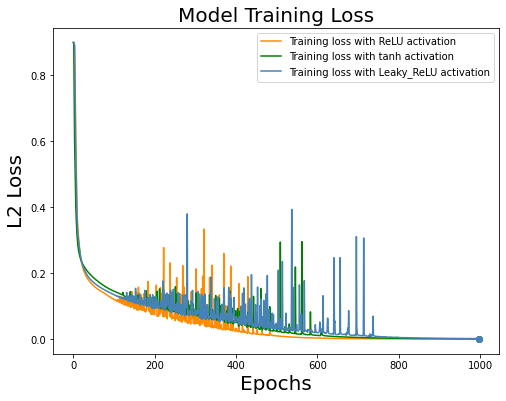

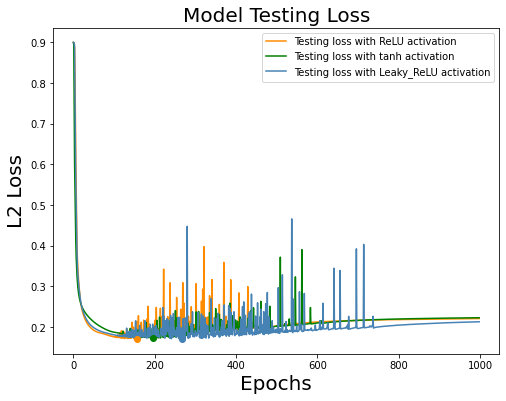

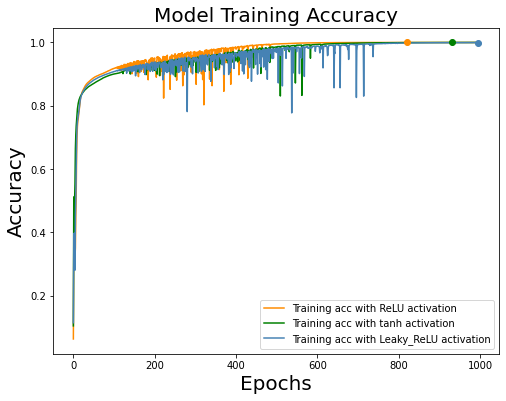

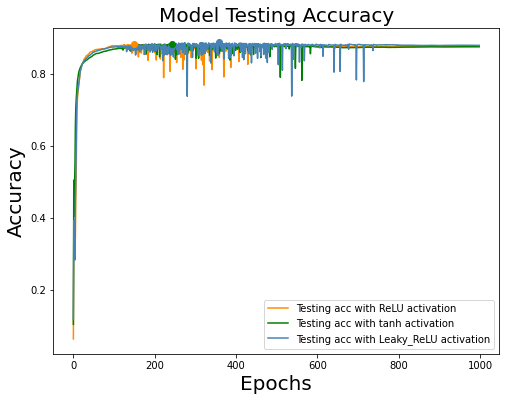

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(metrices_2['training_loss'], label = 'Training loss with ReLU activation', color='darkorange') 
plt.plot(metrices_3['training_loss'], label = 'Training loss with tanh activation', color='green') 
plt.plot(metrices_4['training_loss'], label = 'Training loss with Leaky_ReLU activation', color='steelblue') 
plt.plot(np.argmin(metrices_2['training_loss']),np.min(metrices_2['training_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_3['training_loss']),np.min(metrices_3['training_loss']), marker='o', color='green')
plt.plot(np.argmin(metrices_4['training_loss']),np.min(metrices_4['training_loss']), marker='o', color='steelblue')
plt.title("Model Training Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(metrices_2['testing_loss'], label = 'Testing loss with ReLU activation', color='darkorange') 
plt.plot(metrices_3['testing_loss'], label = 'Testing loss with tanh activation', color='green') 
plt.plot(metrices_4['testing_loss'], label = 'Testing loss with Leaky_ReLU activation', color='steelblue') 
plt.plot(np.argmin(metrices_2['testing_loss']),np.min(metrices_2['testing_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_3['testing_loss']),np.min(metrices_3['testing_loss']), marker='o', color='green')
plt.plot(np.argmin(metrices_4['testing_loss']),np.min(metrices_4['testing_loss']), marker='o', color='steelblue')
plt.title("Model Testing Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(metrices_2['training_acc'], label = 'Training acc with ReLU activation', color='darkorange') 
plt.plot(metrices_3['training_acc'], label = 'Training acc with tanh activation', color='green') 
plt.plot(metrices_4['training_acc'], label = 'Training acc with Leaky_ReLU activation', color='steelblue') 
plt.plot(np.argmax(metrices_2['training_acc']),np.max(metrices_2['training_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_3['training_acc']),np.max(metrices_3['training_acc']), marker='o', color='green')
plt.plot(np.argmax(metrices_4['training_acc']),np.max(metrices_4['training_acc']), marker='o', color='steelblue')
plt.title("Model Training Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))

plt.plot(metrices_2['testing_acc'], label = 'Testing acc with ReLU activation', color='darkorange') 
plt.plot(metrices_3['testing_acc'], label = 'Testing acc with tanh activation', color='green') 
plt.plot(metrices_4['testing_acc'], label = 'Testing acc with Leaky_ReLU activation', color='steelblue')
plt.plot(np.argmax(metrices_2['testing_acc']),np.max(metrices_2['testing_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_3['testing_acc']),np.max(metrices_3['testing_acc']), marker='o', color='green')
plt.plot(np.argmax(metrices_4['testing_acc']),np.max(metrices_4['testing_acc']), marker='o', color='steelblue')
plt.title("Model Testing Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
yh = model_3.predict(X_test_norm) 
y_pred = np.argmax(yh, axis = 1)
accuracy_3 = evaluate_acc(y_pred,Y_test)

yh = model_4.predict(X_test_norm) 
y_pred = np.argmax(yh, axis = 1)
accuracy_4 = evaluate_acc(y_pred,Y_test)

print(f'Test accuracy with ReLU: {accuracy_2*100 :.2f} %')
print(f'Test accuracy with tanh: {accuracy_3*100 :.2f} %')
print(f'Test accuracy with Leaky_ReLU: {accuracy_4*100 :.2f} %')

Test accuracy with ReLU: 87.63 %
Test accuracy with tanh: 87.55 %
Test accuracy with Leaky_ReLU: 87.90 %


In [ ]:
accuracy_3_max = np.max(metrices_3['testing_acc'])
accuracy_4_max = np.max(metrices_4['testing_acc'])

print(f'Max Test accuracy with ReLU: {accuracy_2_max*100 :.2f} %')
print(f'Max Test accuracy with tanh: {accuracy_3_max*100 :.2f} %')
print(f'Max Test accuracy with Leaky_ReLU: {accuracy_4_max*100 :.2f} %')

Max Test accuracy with ReLU: 88.35 %
Max Test accuracy with tanh: 88.36 %
Max Test accuracy with Leaky_ReLU: 88.74 %


Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, add dropout regularization to the network and train the MLP in this way. How does this affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be explored as part of other project requirements.

In [ ]:
model_5 = MLP([128,128], activations=["ReLU","ReLU"], dropout=[0,0.3,0.3])
model_5, metrices_5 = model_5.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

hidden layer activation: ['ReLU', 'ReLU']
Weights of hidden layer 0 = (784, 128)
Weights of hidden layer 1 = (128, 128)
Final layer weights =  (128, 10)
Epoch:  1
2022-03-30 10:03:25.099850   0 / 60000
2022-03-30 10:03:26.161669   20000 / 60000
2022-03-30 10:03:27.239840   40000 / 60000
Epoch:  2
2022-03-30 10:03:29.223362   0 / 60000
2022-03-30 10:03:30.320035   20000 / 60000
2022-03-30 10:03:31.424388   40000 / 60000
Epoch:  3
2022-03-30 10:03:33.455817   0 / 60000
2022-03-30 10:03:34.533834   20000 / 60000
2022-03-30 10:03:35.585592   40000 / 60000
Epoch:  4
2022-03-30 10:03:37.632873   0 / 60000
2022-03-30 10:03:38.706000   20000 / 60000
2022-03-30 10:03:39.759573   40000 / 60000
Epoch:  5
2022-03-30 10:03:41.781735   0 / 60000
2022-03-30 10:03:42.827325   20000 / 60000
2022-03-30 10:03:43.886966   40000 / 60000
Epoch:  6
2022-03-30 10:03:45.898159   0 / 60000
2022-03-30 10:03:46.970893   20000 / 60000
2022-03-30 10:03:48.089056   40000 / 60000
Epoch:  7
2022-03-30 10:03:50.103181 

In [ ]:
# DO NOT RUN, only to save and reload models
#save model weights
np.save(path+"model_5_weights.npy", model_5.params)
np.save(path+"model_5_metrices.npy", metrices_5)

In [ ]:
# DO NOT RUN, only to save and reload models
model_5.params = np.load(path+"model_5_weights.npy", allow_pickle=True).item()
metrices_5 = np.load(path+"model_5_metrices.npy", allow_pickle=True).item()

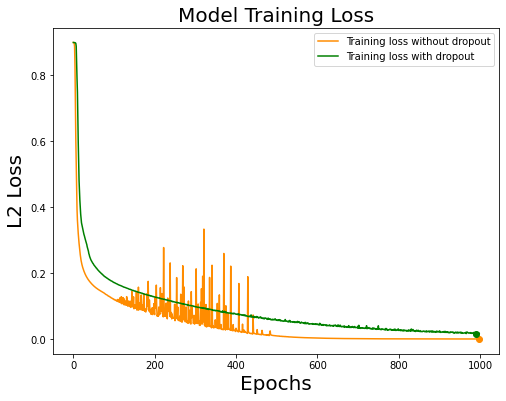

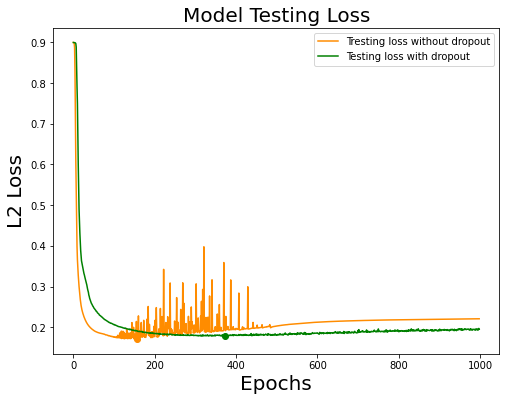

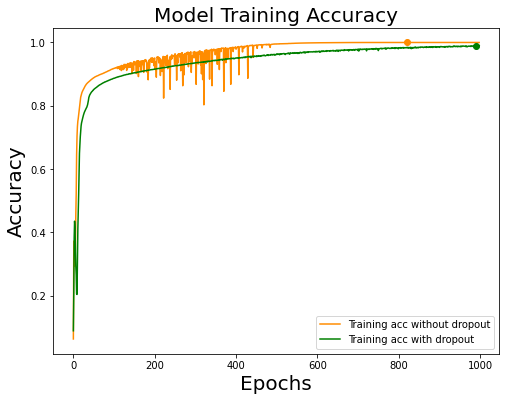

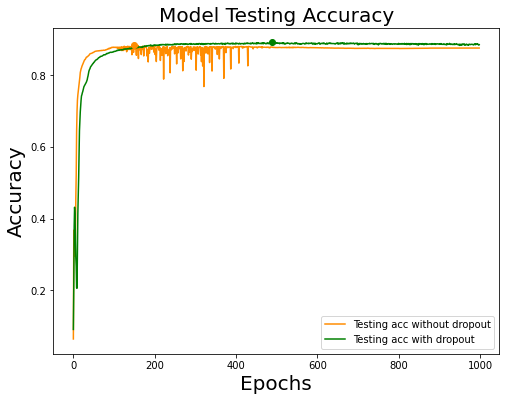

In [ ]:
plt.figure(figsize=(8,6))
plt.plot( metrices_2['training_loss'], label = 'Training loss without dropout', color='darkorange') 
plt.plot( metrices_5['training_loss'], label = 'Training loss with dropout', color='green')
plt.plot(np.argmin(metrices_2['training_loss']),np.min(metrices_2['training_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_5['training_loss']),np.min(metrices_5['training_loss']), marker='o', color='green')
plt.title("Model Training Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['testing_loss'], label = 'Tresting loss without dropout', color='darkorange') 
plt.plot( metrices_5['testing_loss'], label = 'Testing loss with dropout', color='green')
plt.plot(np.argmin(metrices_2['testing_loss']),np.min(metrices_2['testing_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_5['testing_loss']),np.min(metrices_5['testing_loss']), marker='o', color='green')
plt.title("Model Testing Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['training_acc'], label = 'Training acc without dropout', color='darkorange') 
plt.plot( metrices_5['training_acc'], label = 'Training acc with dropout', color='green')
plt.plot(np.argmax(metrices_2['training_acc']),np.max(metrices_2['training_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_5['training_acc']),np.max(metrices_5['training_acc']), marker='o', color='green')
plt.title("Model Training Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['testing_acc'], label = 'Testing acc without dropout', color='darkorange') 
plt.plot( metrices_5['testing_acc'], label = 'Testing acc with dropout', color='green') 
plt.plot(np.argmax(metrices_2['testing_acc']),np.max(metrices_2['testing_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_5['testing_acc']),np.max(metrices_5['testing_acc']), marker='o', color='green')
plt.title("Model Testing Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
yh = model_5.predict(X_test_norm) 
y_pred = np.argmax(yh, axis = 1)
accuracy_5 = evaluate_acc(y_pred,Y_test)

print(f'Test accuracy with no dropout: {accuracy_2*100 :.2f} %')
print(f'Test accuracy with dropout: {accuracy_5*100 :.2f} %')

Test accuracy with no dropout: 87.63 %
Test accuracy with dropout: 88.60 %


In [ ]:
accuracy_5_max = np.max(metrices_5['testing_acc'])

print(f'Max Test accuracy with no dropout: {accuracy_2_max*100 :.2f} %')
print(f'Max Test accuracy with dropout: {accuracy_5_max*100 :.2f} %')

Max Test accuracy with no dropout: 88.35 %
Max Test accuracy with dropout: 89.19 %


Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, train it with unnormalized images. How does this affect the accuracy?

In [ ]:
optimizer = GradientDescent(learning_rate=1e-2, max_epochs= 1000, batch_size= 1000)

model_6 = MLP([128,128], activations=["ReLU","ReLU"])
model_6, metrices_6 = model_6.fit(X_train_unnorm, Y_train, optimizer,track_matrices=True)

hidden layer activation: ['ReLU', 'ReLU']
Weights of hidden layer 0 = (784, 128)
Weights of hidden layer 1 = (128, 128)
Final layer weights =  (128, 10)
Epoch:  1
2022-03-30 11:09:30.275845   0 / 60000
2022-03-30 11:09:31.069189   20000 / 60000
2022-03-30 11:09:31.844769   40000 / 60000
Epoch:  2
2022-03-30 11:09:33.515742   0 / 60000
2022-03-30 11:09:34.095939   20000 / 60000
2022-03-30 11:09:34.711977   40000 / 60000
Epoch:  3
2022-03-30 11:09:36.229333   0 / 60000
2022-03-30 11:09:36.819215   20000 / 60000
2022-03-30 11:09:37.448358   40000 / 60000
Epoch:  4
2022-03-30 11:09:38.964653   0 / 60000
2022-03-30 11:09:39.580012   20000 / 60000
2022-03-30 11:09:40.166352   40000 / 60000
Epoch:  5
2022-03-30 11:09:41.729692   0 / 60000
2022-03-30 11:09:42.325848   20000 / 60000
2022-03-30 11:09:42.927790   40000 / 60000
Epoch:  6
2022-03-30 11:09:44.425250   0 / 60000
2022-03-30 11:09:45.020128   20000 / 60000
2022-03-30 11:09:45.610410   40000 / 60000
Epoch:  7
2022-03-30 11:09:47.130057 

In [ ]:
# DO NOT RUN, only to save and reload models
#save model weights
np.save(path+"model_6_weights.npy", model_6.params)
np.save(path+"model_6_metrices.npy", metrices_6)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
# DO NOT RUNreload models
metrices_6 = np.load(path+"model_6_metrices.npy", allow_pickle=True).item()

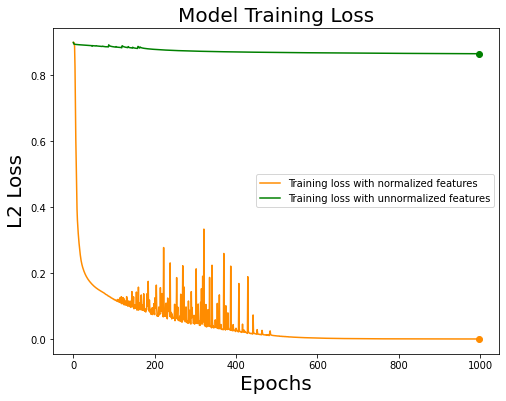

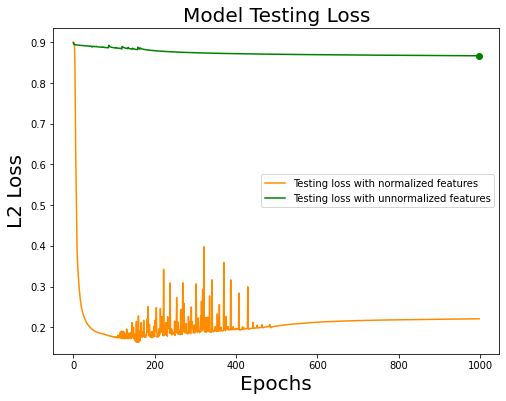

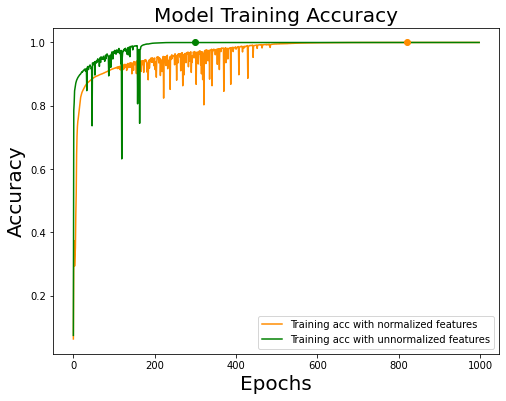

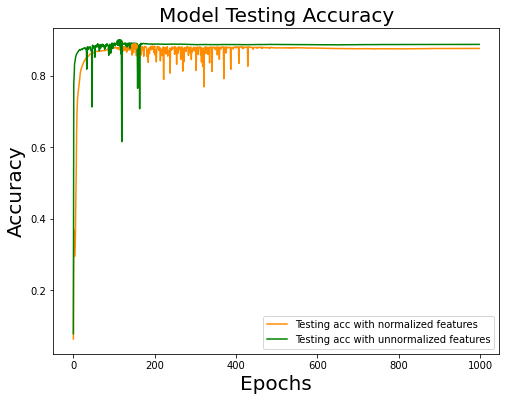

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(metrices_2['training_loss'], label = 'Training loss with normalized features', color='darkorange') 
plt.plot(metrices_6['training_loss'], label = 'Training loss with unnormalized features', color='green')
plt.plot(np.argmin(metrices_2['training_loss']),np.min(metrices_2['training_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_6['training_loss']),np.min(metrices_6['training_loss']), marker='o', color='green')

plt.title("Model Training Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(metrices_2['testing_loss'], label = 'Testing loss with normalized features', color='darkorange') 
plt.plot(metrices_6['testing_loss'], label = 'Testing loss with unnormalized features', color='green')  
plt.plot(np.argmin(metrices_2['testing_loss']),np.min(metrices_2['testing_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_6['testing_loss']),np.min(metrices_6['testing_loss']), marker='o', color='green')
plt.title("Model Testing Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(metrices_2['training_acc'], label = 'Training acc with normalized features', color='darkorange' ) 
plt.plot(metrices_6['training_acc'], label = 'Training acc with unnormalized features', color='green')
plt.plot(np.argmax(metrices_2['training_acc']),np.max(metrices_2['training_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_6['training_acc']),np.max(metrices_6['training_acc']), marker='o', color='green')
plt.title("Model Training Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(metrices_2['testing_acc'], label = 'Testing acc with normalized features', color='darkorange') 
plt.plot(metrices_6['testing_acc'], label = 'Testing acc with unnormalized features', color='green')
plt.plot(np.argmax(metrices_2['testing_acc']),np.max(metrices_2['testing_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_6['testing_acc']),np.max(metrices_6['testing_acc']), marker='o', color='green')
plt.title("Model Testing Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
yh = model_6.predict(X_test_unnorm) 
y_pred = np.argmax(yh, axis = 1)
accuracy_6 = evaluate_acc(y_pred,Y_test)

print(f'Test accuracy with normalized features: {accuracy_2*100 :.2f} %')
print(f'Test accuracy with unnormalized features: {accuracy_6*100 :.2f} %')

Test accuracy with normalized features: 87.63 %
Test accuracy with unnormalized features: 88.77 %


In [ ]:
accuracy_6_max = np.max(metrices_6['testing_acc'])

print(f'Max Test accuracy with normalized features: {accuracy_2_max*100 :.2f} %')
print(f'Max Test accuracy with unnormalized features: {accuracy_6_max*100 :.2f} %')

Max Test accuracy with normalized features: 88.35 %
Max Test accuracy with unnormalized features: 89.30 %


Using existing libraries such as TensorFlow or PyTorch, create a convolutional neural network (CNN) with 2 convolutional and 2 fully connected layers. Although you are free in your choice of the hyperparameters of the convolutional layers, set the number of units in the fully connected layers to be 128. Also, set the activations in all of the layers to be ReLU. Train this CNN on the Fashion-MNIST dataset. Does using a CNN increase/decrease the accuracy compared to using MLPs? Provide comments on your results.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
#Define a CNN
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1))) # 1st CNN layer
model.add(layers.MaxPooling2D((2, 2)))                                            # max pooling layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))                          # 2nd CNN layer


model.add(layers.Flatten())                                      # flatten the output before passing it to fully connected layer
model.add(layers.Dense(128, activation='relu'))                  # 1st fully connected layer
model.add(layers.Dense(10, activation='softmax'))                # 2nd fully connected layer

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Compile the  Model
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size = 1000, epochs=50, validation_data=(test_images, test_labels))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 128)               1982592   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

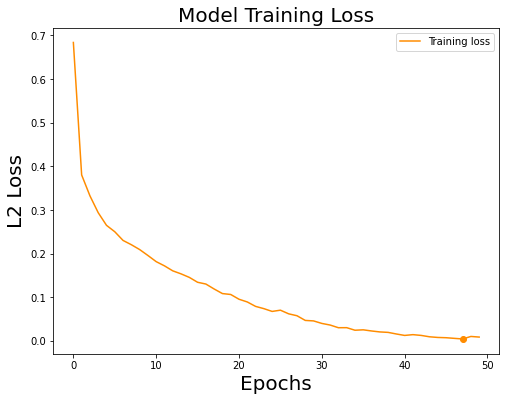

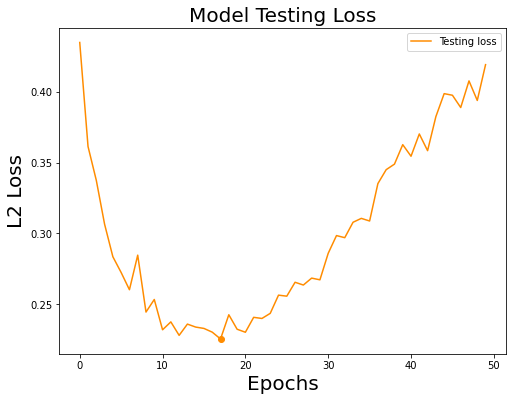

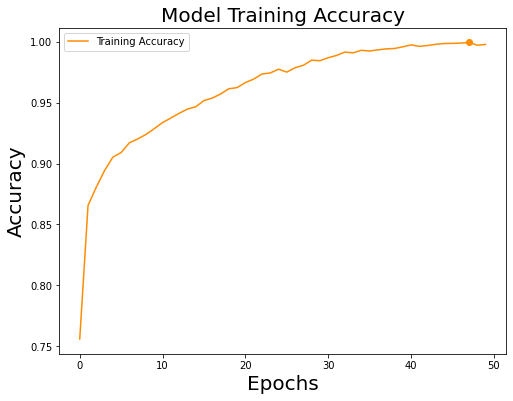

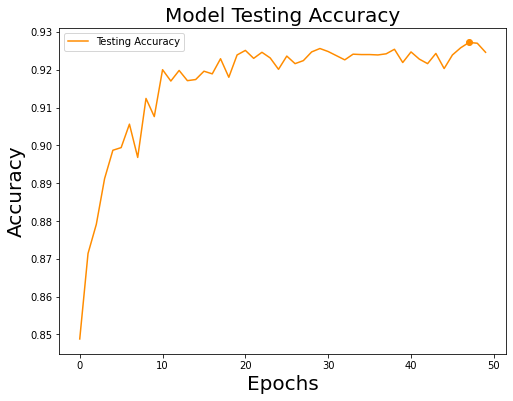

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label = 'Training loss', color='darkorange') 
plt.plot(np.argmin(history.history['loss']),np.min(history.history['loss']), marker='o', color='darkorange')
plt.title("Model Training Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['val_loss'], label = 'Testing loss', color='darkorange') 
plt.plot(np.argmin(history.history['val_loss']),np.min(history.history['val_loss']), marker='o', color='darkorange')
plt.title("Model Testing Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color='darkorange') 
plt.plot(np.argmax(history.history['accuracy']),np.max(history.history['accuracy']), marker='o', color='darkorange')
plt.title("Model Training Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['val_accuracy'], label = 'Testing Accuracy', color='darkorange') 
plt.plot(np.argmax(history.history['val_accuracy']),np.max(history.history['val_accuracy']), marker='o', color='darkorange')
plt.title("Model Testing Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

#Test accuracy
print(f'Test accuracy of CNN: {test_acc*100 :.2f} %')

max_acc = np.max(np.array(history.history['val_accuracy']))
print(f'Max Test accuracy of CNN: {max_acc*100 :.2f} %')



313/313 - 2s - loss: 0.4192 - accuracy: 0.9246 - 2s/epoch - 7ms/step
Test accuracy of CNN: 92.46 %
Max Test accuracy of CNN: 92.72 %


## Finding the best model
Using your MLP implementation, try to come up with an MLP architecture that performs as good as possible. How does this MLP perform compared to the CNN in part 5? Justify your choice of network architecture parameters through careful experiments.

In [ ]:
lrs = [5e-3 ,1e-2, 5e-2, 1e-1, 5e-1]

highest_accuracy = 0

for lr in lrs:
  optimizer = GradientDescent(learning_rate=lr, max_epochs = 200, batch_size= 1000)
  model = MLP([128,128], activations=["LeakyReLU","LeakyReLU"], dropout=[0,0.3,0.3])
  model, metrices = model.fit(X_train_norm, Y_train, optimizer, track_matrices=True)
  print(f"lr = {lr} accur= {np.max(metrices['testing_acc'])}")
  if np.max(metrices['testing_acc']) > highest_accuracy:
    best_lr = lr
    best_model = model
    best_metrices = metrices

print('Best model lr = ', best_lr)
print(f"Best model accuracy: {np.max(best_metrices['testing_acc'])}")

In [ ]:
optimizer = GradientDescent(learning_rate=0.1, max_epochs = 300, batch_size= 1000)
model = MLP([128,256], activations=["LeakyReLU","LeakyReLU"], dropout=[0,0.3,0.3])
model, metrices = model.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

hidden layer activation: ['LeakyReLU', 'LeakyReLU']
Weights of hidden layer 0 = (784, 128)
Weights of hidden layer 1 = (128, 256)
Final layer weights =  (256, 10)
Epoch:  1
2022-04-04 01:17:17.964788   0 / 60000
2022-04-04 01:17:19.311120   20000 / 60000
2022-04-04 01:17:20.665395   40000 / 60000
Epoch:  2
2022-04-04 01:17:24.216950   0 / 60000
2022-04-04 01:17:26.995943   20000 / 60000
2022-04-04 01:17:28.417782   40000 / 60000
Epoch:  3
2022-04-04 01:17:31.116069   0 / 60000
2022-04-04 01:17:32.501086   20000 / 60000
2022-04-04 01:17:33.852843   40000 / 60000
Epoch:  4
2022-04-04 01:17:36.568225   0 / 60000
2022-04-04 01:17:37.928885   20000 / 60000
2022-04-04 01:17:39.316095   40000 / 60000
Epoch:  5
2022-04-04 01:17:42.026653   0 / 60000
2022-04-04 01:17:43.369191   20000 / 60000
2022-04-04 01:17:44.745177   40000 / 60000
Epoch:  6
2022-04-04 01:17:47.413414   0 / 60000
2022-04-04 01:17:48.810440   20000 / 60000
2022-04-04 01:17:50.489982   40000 / 60000
Epoch:  7
2022-04-04 01:17:

In [ ]:
optimizer = GradientDescent(learning_rate=0.1, max_epochs = 1000, batch_size= 1000)
model = MLP([128,128], activations=["LeakyReLU","LeakyReLU"], dropout=[0,0.3,0.3])
model, metrices = model.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

hidden layer activation: ['LeakyReLU', 'LeakyReLU']
Weights of hidden layer 0 = (784, 128)
Weights of hidden layer 1 = (128, 128)
Final layer weights =  (128, 10)
Epoch:  1
2022-04-04 03:58:41.344647   0 / 60000
2022-04-04 03:58:42.908453   20000 / 60000
2022-04-04 03:58:44.542113   40000 / 60000
Epoch:  2
2022-04-04 03:58:46.744535   0 / 60000
2022-04-04 03:58:47.905197   20000 / 60000
2022-04-04 03:58:49.124825   40000 / 60000
Epoch:  3
2022-04-04 03:58:51.360195   0 / 60000
2022-04-04 03:58:52.555749   20000 / 60000
2022-04-04 03:58:53.756404   40000 / 60000
Epoch:  4
2022-04-04 03:58:56.000335   0 / 60000
2022-04-04 03:58:57.201134   20000 / 60000
2022-04-04 03:58:58.413608   40000 / 60000
Epoch:  5
2022-04-04 03:59:00.644638   0 / 60000
2022-04-04 03:59:01.796820   20000 / 60000
2022-04-04 03:59:02.953944   40000 / 60000
Epoch:  6
2022-04-04 03:59:05.133027   0 / 60000
2022-04-04 03:59:06.334302   20000 / 60000
2022-04-04 03:59:07.519212   40000 / 60000
Epoch:  7
2022-04-04 03:59:

In [ ]:
model_Best = MLP([128,128], activations=["relu","relu"], dropout=[0,0.3,0.3])
model_Best, metrices_Best = model_Best.fit(X_train_norm, Y_train, optimizer, track_matrices=True)

accuracy_best = np.max(metrices_Best['testing_acc'])
print(f'Max Test accuracy of our best model: {accuracy_best*100 :.2f} %')

## Max Epochs before overfitting
You can report your findings either in the form of a table or a plot in the write-up. However, include in your colab notebooks the plots of the test and train performance of the MLPs/CNN as a function of training epochs. This will allow you to see how much the network should be trained before it starts to overfit to the training data.

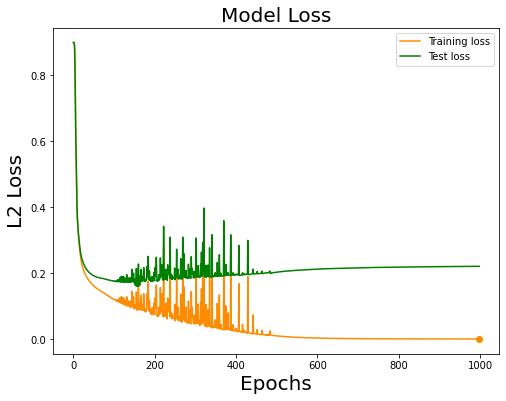

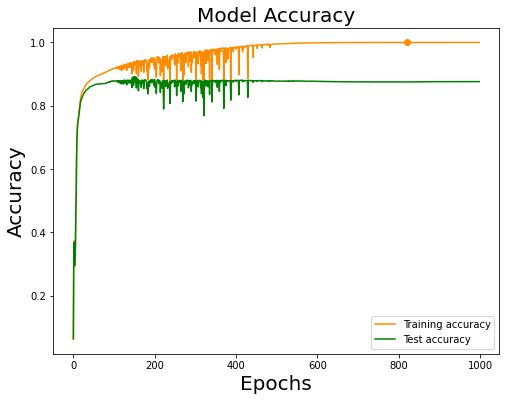

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(metrices_2['training_loss'], label = 'Training loss', color='darkorange')
plt.plot(metrices_2['testing_loss'], label = 'Test loss', color='green') 
plt.plot(np.argmin(metrices_2['training_loss']),np.min(metrices_2['training_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_2['testing_loss']),np.min(metrices_2['testing_loss']), marker='o', color='green')
plt.title("Model Loss", fontsize=20)

plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))

plt.plot(metrices_2['training_acc'], label = 'Training accuracy', color='darkorange') 
plt.plot(metrices_2['testing_acc'], label = 'Test accuracy', color='green') 
plt.plot(np.argmax(metrices_2['training_acc']),np.max(metrices_2['training_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_2['testing_acc']),np.max(metrices_2['testing_acc']), marker='o', color='green')
plt.title("Model Accuracy", fontsize=20)

plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

##L2 regularization

In [ ]:
class GradientDescent_withL2:
  '''
  GradientDescent class implements a optimizer that would perform gradient descent.

  Parameters:
    learning_rate: double :
      The learning rate of the optimizer. Default is 0.01.
   max_epochs: int : 
      Maximum number of training iteration over the entire dataset. Default is 1000.
  epsilon: dobule :
      Gradient tolerance below which the gradient descent would stop. Default is 1e-8.
  batch_size : int :
      Batch size for min batch gradient descent. For SGD, set to 1. Default is 1000.
      If len(dataset) < batch_size, all instances will be used per iteration.
  L2 regularization: double:
      L2 regularization constant
  Returns:
    GradientDescent instance.  
  '''

  def __init__(self, learning_rate = 1e-3, max_epochs=1e3, epsilon=1e-8, batch_size = 1000, L2 = None):
    self.learning_rate = learning_rate
    self.max_epochs = max_epochs
    self.epsilon = epsilon
    self.batch_size = batch_size
    self.L2 = L2
      
  def run(self, model, gradient_fn, x, y, track_matrices):
    
    metrices = {}
    metrices['training_loss'] = []
    metrices['training_acc'] = []
    metrices['testing_loss'] = []
    metrices['testing_acc'] = []
    
    indices = np.arange(len(y))
    K = len(indices)//self.batch_size
    if K <=0:
      K = 1
    batches =  np.array_split(indices, K)
    training_loss = []
    
    norms = np.array([np.inf])
    t = 1
    while np.any(norms > self.epsilon) and t < self.max_epochs:

      if track_matrices:
        yh = model.predict(X_train_norm) 
        y_pred = np.argmax(yh, axis = 1)
        acc = evaluate_acc(y_pred,Y_train)
        metrices['training_loss'].append(L2Loss(yh,Y_train))
        metrices['training_acc'].append(acc)

        yh = model.predict(X_test_norm) 
        y_pred = np.argmax(yh, axis = 1)
        acc = evaluate_acc(y_pred,Y_test)      
        metrices['testing_loss'].append(L2Loss(yh,Y_test))
        metrices['testing_acc'].append(acc)
      
      print("Epoch: ",t)
    
      for batch in batches:
        grad = gradient_fn(x[batch,:], y[batch], model.params)
        for p in range(len(model.params)):
          if self.L2 is not None:
            grad[p] += grad[p] * self.L2
          model.params[p] -= self.learning_rate * grad[p]            
        norms = np.array([np.linalg.norm(g) for g in grad])
        if np.any(norms < self.epsilon):
          break
        if (batch[0]%(len(indices)//3)==0):
          print(datetime.now(), " ",batch[0],"/" , len(indices) )
      
      t += 1
    
    if t >= self.max_epochs:
      print('Max epoch reached')
    else:
      print('Minimum gradient tolerance reached, possibly vanishing gradient')

    metrices['training_loss'] = np.array(metrices['training_loss'])
    metrices['training_acc'] = np.array(metrices['training_acc'])
    metrices['testing_loss'] = np.array(metrices['testing_loss'])
    metrices['testing_acc'] = np.array(metrices['testing_acc'])
    return metrices

In [ ]:
optimizer = GradientDescent_withL2(learning_rate=0.1, max_epochs= 1000, batch_size= 1000, L2 = 2.0)

model_with_L2 = MLP([128,128], activations=["ReLU","ReLU"])
model_with_L2, metrices_with_L2 = model_with_L2.fit(X_train_norm, Y_train, optimizer,track_matrices=True)

hidden layer activation: ['ReLU', 'ReLU']
Weights of hidden layer 0 = (784, 128)
Weights of hidden layer 1 = (128, 128)
Final layer weights =  (128, 10)
Epoch:  1
2022-04-04 07:30:16.646096   0 / 60000
2022-04-04 07:30:17.278636   20000 / 60000
2022-04-04 07:30:17.877016   40000 / 60000
Epoch:  2
2022-04-04 07:30:19.410745   0 / 60000
2022-04-04 07:30:20.013503   20000 / 60000
2022-04-04 07:30:20.634635   40000 / 60000
Epoch:  3
2022-04-04 07:30:22.074973   0 / 60000
2022-04-04 07:30:22.674852   20000 / 60000
2022-04-04 07:30:23.242907   40000 / 60000
Epoch:  4
2022-04-04 07:30:24.678091   0 / 60000
2022-04-04 07:30:25.242111   20000 / 60000
2022-04-04 07:30:25.809568   40000 / 60000
Epoch:  5
2022-04-04 07:30:27.251295   0 / 60000
2022-04-04 07:30:27.837915   20000 / 60000
2022-04-04 07:30:28.396515   40000 / 60000
Epoch:  6
2022-04-04 07:30:29.824828   0 / 60000
2022-04-04 07:30:30.402320   20000 / 60000
2022-04-04 07:30:30.995439   40000 / 60000
Epoch:  7
2022-04-04 07:30:32.414463 

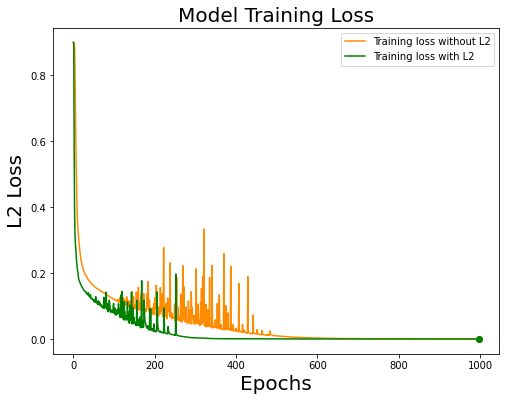

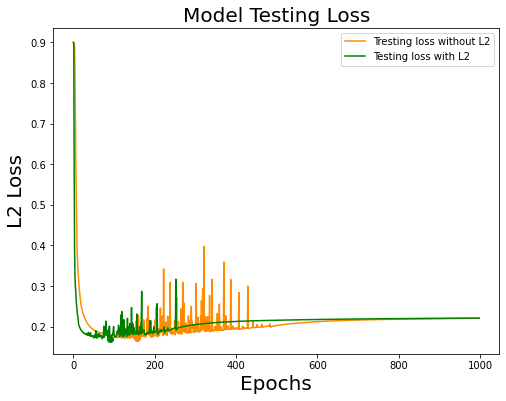

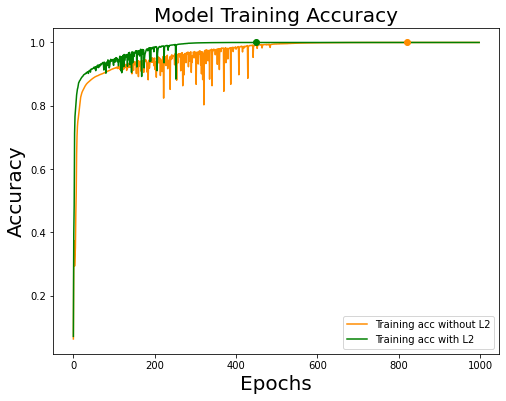

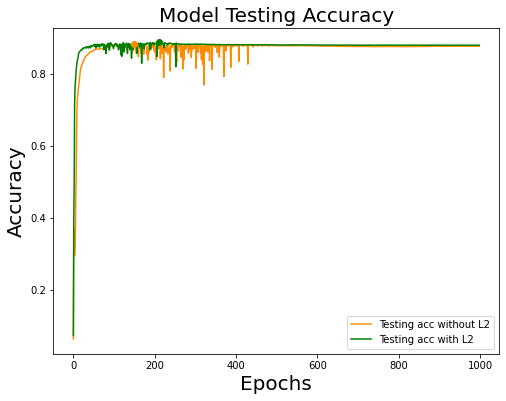

In [ ]:
plt.figure(figsize=(8,6))
plt.plot( metrices_2['training_loss'], label = 'Training loss without L2', color='darkorange') 
plt.plot( metrices_with_L2['training_loss'], label = 'Training loss with L2', color='green')
plt.plot(np.argmin(metrices_2['training_loss']),np.min(metrices_with_L2['training_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_with_L2['training_loss']),np.min(metrices_with_L2['training_loss']), marker='o', color='green')
plt.title("Model Training Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['testing_loss'], label = 'Tresting loss without L2', color='darkorange') 
plt.plot( metrices_with_L2['testing_loss'], label = 'Testing loss with L2', color='green')
plt.plot(np.argmin(metrices_2['testing_loss']),np.min(metrices_2['testing_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_with_L2['testing_loss']),np.min(metrices_with_L2['testing_loss']), marker='o', color='green')
plt.title("Model Testing Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['training_acc'], label = 'Training acc without L2', color='darkorange') 
plt.plot( metrices_with_L2['training_acc'], label = 'Training acc with L2', color='green')
plt.plot(np.argmax(metrices_2['training_acc']),np.max(metrices_2['training_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_with_L2['training_acc']),np.max(metrices_with_L2['training_acc']), marker='o', color='green')
plt.title("Model Training Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['testing_acc'], label = 'Testing acc without L2', color='darkorange') 
plt.plot( metrices_with_L2['testing_acc'], label = 'Testing acc with L2', color='green') 
plt.plot(np.argmax(metrices_2['testing_acc']),np.max(metrices_2['testing_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_with_L2['testing_acc']),np.max(metrices_with_L2['testing_acc']), marker='o', color='green')
plt.title("Model Testing Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
accuracy_with_L2 = np.max(metrices_with_L2['testing_acc'])

print(f'Max Test accuracy without L2 regularization: {accuracy_2_max*100 :.2f} %')
print(f'Max Test accuracy without L2 regularization: {accuracy_with_L2*100 :.2f} %')

Max Test accuracy without L2 regularization: 88.35 %
Max Test accuracy without L2 regularization: 88.66 %


## Weights Decay

In [ ]:
class GradientDescent_weightdecay:
  '''
  GradientDescent class implements a optimizer that would perform gradient descent.

  Parameters:
    learning_rate: double :
      The learning rate of the optimizer. Default is 0.01.
   max_epochs: int : 
      Maximum number of training iteration over the entire dataset. Default is 1000.
  epsilon: dobule :
      Gradient tolerance below which the gradient descent would stop. Default is 1e-8.
  batch_size : int :
      Batch size for min batch gradient descent. For SGD, set to 1. Default is 1000.
      If len(dataset) < batch_size, all instances will be used per iteration.
  L2 regularization: double:
      L2 regularization constant
  Returns:
    GradientDescent instance.  
  '''

  def __init__(self, learning_rate = 1e-3, max_epochs=1e3, epsilon=1e-8, batch_size = 1000, weightdecay = None):
    self.learning_rate = learning_rate
    self.max_epochs = max_epochs
    self.epsilon = epsilon
    self.batch_size = batch_size
    self.weightdecay = weightdecay
      
  def run(self, model, gradient_fn, x, y, track_matrices):
    
    metrices = {}
    metrices['training_loss'] = []
    metrices['training_acc'] = []
    metrices['testing_loss'] = []
    metrices['testing_acc'] = []
    
    indices = np.arange(len(y))
    K = len(indices)//self.batch_size
    if K <=0:
      K = 1
    batches =  np.array_split(indices, K)
    training_loss = []
    
    norms = np.array([np.inf])
    t = 1
    while np.any(norms > self.epsilon) and t < self.max_epochs:

      if track_matrices:
        yh = model.predict(X_train_norm) 
        y_pred = np.argmax(yh, axis = 1)
        acc = evaluate_acc(y_pred,Y_train)
        metrices['training_loss'].append(L2Loss(yh,Y_train))
        metrices['training_acc'].append(acc)

        yh = model.predict(X_test_norm) 
        y_pred = np.argmax(yh, axis = 1)
        acc = evaluate_acc(y_pred,Y_test)      
        metrices['testing_loss'].append(L2Loss(yh,Y_test))
        metrices['testing_acc'].append(acc)
      
      print("Epoch: ",t)
    
      for batch in batches:
        grad = gradient_fn(x[batch,:], y[batch], model.params)
        for p in range(len(model.params)):
          if self.weightdecay is not None:
            model.params[p] *= (1-self.weightdecay)
          model.params[p] -= self.learning_rate * grad[p]            
        norms = np.array([np.linalg.norm(g) for g in grad])
        if np.any(norms < self.epsilon):
          break
        if (batch[0]%(len(indices)//3)==0):
          print(datetime.now(), " ",batch[0],"/" , len(indices) )
      
      t += 1
    
    if t >= self.max_epochs:
      print('Max epoch reached')
    else:
      print('Minimum gradient tolerance reached, possibly vanishing gradient')

    metrices['training_loss'] = np.array(metrices['training_loss'])
    metrices['training_acc'] = np.array(metrices['training_acc'])
    metrices['testing_loss'] = np.array(metrices['testing_loss'])
    metrices['testing_acc'] = np.array(metrices['testing_acc'])
    return metrices

In [ ]:
optimizer = GradientDescent_weightdecay(learning_rate=0.1, max_epochs= 1000, batch_size= 1000, weightdecay = 0.0001)

model_with_weightdecay= MLP([128,128], activations=["ReLU","ReLU"])
model_with_weightdecay, metrices_with_weightdecay = model_with_weightdecay.fit(X_train_norm, Y_train, optimizer,track_matrices=True)

hidden layer activation: ['ReLU', 'ReLU']
Weights of hidden layer 0 = (784, 128)
Weights of hidden layer 1 = (128, 128)
Final layer weights =  (128, 10)
Epoch:  1
2022-04-04 23:06:21.783073   0 / 60000
2022-04-04 23:06:22.298134   20000 / 60000
2022-04-04 23:06:22.813373   40000 / 60000
Epoch:  2
2022-04-04 23:06:24.144232   0 / 60000
2022-04-04 23:06:24.645290   20000 / 60000
2022-04-04 23:06:25.157797   40000 / 60000
Epoch:  3
2022-04-04 23:06:26.736304   0 / 60000
2022-04-04 23:06:27.249138   20000 / 60000
2022-04-04 23:06:27.742511   40000 / 60000
Epoch:  4
2022-04-04 23:06:29.018818   0 / 60000
2022-04-04 23:06:29.506227   20000 / 60000
2022-04-04 23:06:30.020401   40000 / 60000
Epoch:  5
2022-04-04 23:06:31.258388   0 / 60000
2022-04-04 23:06:31.734737   20000 / 60000
2022-04-04 23:06:32.240574   40000 / 60000
Epoch:  6
2022-04-04 23:06:33.469171   0 / 60000
2022-04-04 23:06:34.007995   20000 / 60000
2022-04-04 23:06:34.516995   40000 / 60000
Epoch:  7
2022-04-04 23:06:35.736469 

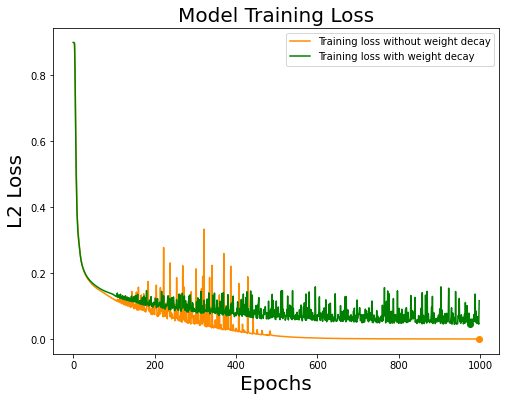

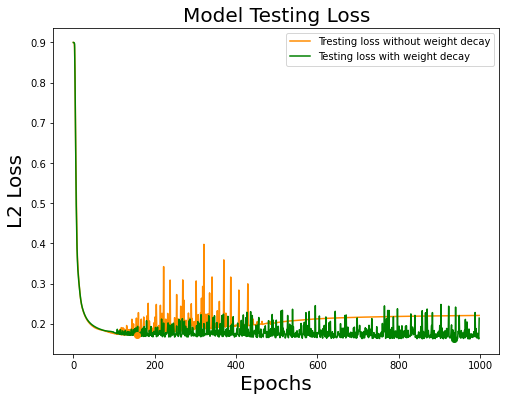

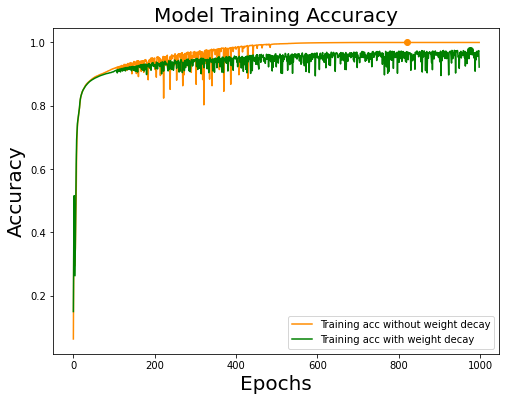

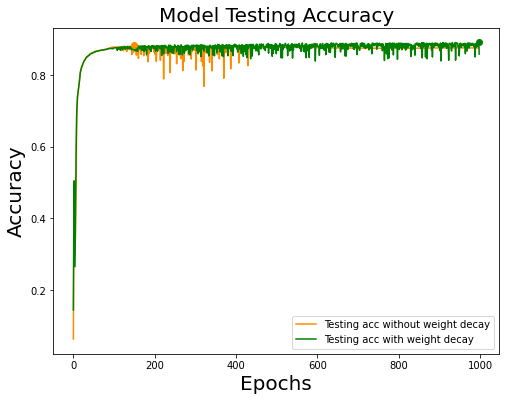

In [ ]:
plt.figure(figsize=(8,6))
plt.plot( metrices_2['training_loss'], label = 'Training loss without weight decay', color='darkorange') 
plt.plot( metrices_with_weightdecay['training_loss'], label = 'Training loss with weight decay', color='green')
plt.plot(np.argmin(metrices_2['training_loss']),np.min(metrices_2['training_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_with_weightdecay['training_loss']),np.min(metrices_with_weightdecay['training_loss']), marker='o', color='green')
plt.title("Model Training Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['testing_loss'], label = 'Tresting loss without weight decay', color='darkorange') 
plt.plot( metrices_with_weightdecay['testing_loss'], label = 'Testing loss with weight decay', color='green')
plt.plot(np.argmin(metrices_2['testing_loss']),np.min(metrices_2['testing_loss']), marker='o', color='darkorange')
plt.plot(np.argmin(metrices_with_weightdecay['testing_loss']),np.min(metrices_with_weightdecay['testing_loss']), marker='o', color='green')
plt.title("Model Testing Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("L2 Loss", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['training_acc'], label = 'Training acc without weight decay', color='darkorange') 
plt.plot( metrices_with_weightdecay['training_acc'], label = 'Training acc with weight decay', color='green')
plt.plot(np.argmax(metrices_2['training_acc']),np.max(metrices_2['training_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_with_weightdecay['training_acc']),np.max(metrices_with_weightdecay['training_acc']), marker='o', color='green')
plt.title("Model Training Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot( metrices_2['testing_acc'], label = 'Testing acc without weight decay', color='darkorange') 
plt.plot( metrices_with_weightdecay['testing_acc'], label = 'Testing acc with weight decay', color='green') 
plt.plot(np.argmax(metrices_2['testing_acc']),np.max(metrices_2['testing_acc']), marker='o', color='darkorange')
plt.plot(np.argmax(metrices_with_weightdecay['testing_acc']),np.max(metrices_with_weightdecay['testing_acc']), marker='o', color='green')
plt.title("Model Testing Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
accuracy_with_weightDecay = np.max(metrices_with_weightdecay['testing_acc'])

print(f'Max Test accuracy without weigth decay: {accuracy_2_max*100 :.2f} %')
print(f'Max Test accuracy with weigth decay: {accuracy_with_weightDecay*100 :.2f} %')

Max Test accuracy without weigth decay: 88.35 %
Max Test accuracy with weigth decay: 89.15 %
